In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
warnings.filterwarnings("ignore")
from sklearn.tree import plot_tree
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
data = pd.read_csv('Hitters.csv')
data = pd.get_dummies(data, columns=['League','Division','NewLeague'])
target = 'Salary'
data = data[data['Salary'].notnull()]

In [3]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones': predicciones,
        'y': y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q = bins, labels=False) + 1
    grouped = df_calibracion.groupby('bins').mean()
    plt.plot(grouped.predicciones, grouped.y, marker='o', label = 'Modelo', color = 'skyblue')
    plt.plot(grouped.predicciones, grouped.predicciones, marker='o', label = 'Real', color = 'indianred')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.legend()
    plt.grid()

## Regresión lineal Examen

### Feature Engineering

In [4]:
# De rendimiento actual
data['Hits_per_AtBat'] = data['Hits'] / data['AtBat']
data['HmRun_per_Hits'] = data['HmRun'] / data['Hits']
data['RBIs_per_Hits'] = data['RBI'] / data['Hits']
data['Runs_per_Hits'] = data['Runs'] / data['Hits']

# De rendimiento histórico
data['CHits_per_CAtBat'] = data['CHits'] / data['CAtBat']
data['CHmRun_per_CHits'] = data['CHmRun'] / data['CHits']
data['CRuns_per_CHits'] = data['CRuns'] / data['CHits']
data['Years_AvgHits'] = data['CHits'] / data['Years']

# Transformaciones
data['log_CRuns'] = np.log(data['CRuns']+1)
data['sqrt_CHits'] = np.sqrt(data['CHits']+1)

In [5]:
X = data.copy()
X = X.drop(columns=[target])
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'R2: {r2_score(y_test, y_pred):.4f}')

R2: 0.7134


El r2 obtenido con la regresión lineal es de 0.7134, lo que significa que se explica el 71.34% de la variación de los datos, siendo así un buen modelo. Este fue el mejor modelo obtenido en el examen, posteriormente haremos una regresión con una red neuronal para ver los resultados.

## Random Forest

In [7]:
# Grid search 
pipeline = Pipeline([
    ('rf', RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42))
])

params = {
    'rf__max_depth': list(range(1, 15)),
    'rf__max_features': ['sqrt', 'log2', 10, len(X_train.keys())]
}

rf_grid = GridSearchCV(estimator=pipeline, param_grid=params, cv=5, n_jobs=-1, scoring='r2')
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf',
                                        RandomForestRegressor(n_estimators=300,
                                                              n_jobs=-1,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                           12, 13, 14],
                         'rf__max_features': ['sqrt', 'log2', 10, 32]},
             scoring='r2')

In [8]:
rf_grid.best_params_

{'rf__max_depth': 9, 'rf__max_features': 10}

In [9]:
best_model = rf_grid.best_estimator_.named_steps['rf']

predicciones_rf = best_model.predict(X_test)
print(f'R2: {r2_score(y_pred=predicciones_rf, y_true=y_test):.4f}')

R2: 0.4972


## Modelos sin feature engineering

### Regresión lineal

In [10]:
data = pd.read_csv('Hitters.csv')
data = pd.get_dummies(data, columns=['League','Division','NewLeague'])
target = 'Salary'
data = data[data['Salary'].notnull()]

X = data.copy()
X = X.drop(columns=[target])
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'R2: {r2_score(y_test, y_pred):.4f}')

R2: 0.2907


### Random Forest

In [12]:
# Grid search 
pipeline = Pipeline([
    ('rf', RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42))
])

params = {
    'rf__max_depth': list(range(1, 15)),
    'rf__max_features': ['sqrt', 'log2', 10, len(X_train.keys())]
}

rf_grid = GridSearchCV(estimator=pipeline, param_grid=params, cv=5, n_jobs=-1, scoring='r2')
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf',
                                        RandomForestRegressor(n_estimators=300,
                                                              n_jobs=-1,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                           12, 13, 14],
                         'rf__max_features': ['sqrt', 'log2', 10, 22]},
             scoring='r2')

In [13]:
best_model = rf_grid.best_estimator_.named_steps['rf']

predicciones_rf = best_model.predict(X_test)
print(f'R2: {r2_score(y_pred=predicciones_rf, y_true=y_test):.4f}')

R2: 0.4757


## Conclusiones

### Calibración de regresión lineal

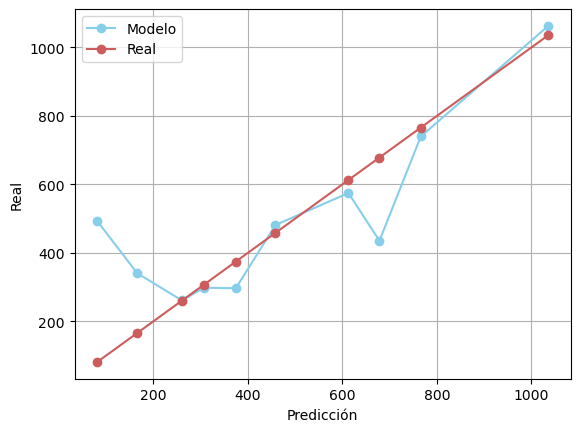

In [14]:
calibracion(y_pred, y_test, 10)

### Calibración de random forest

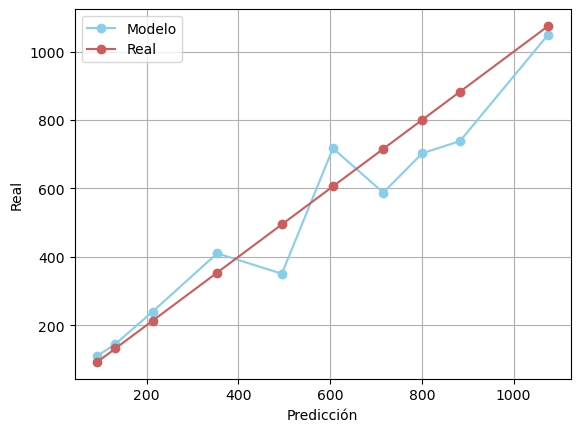

In [15]:
calibracion(predicciones_rf, y_test, 10)

In [16]:
model_interpretability = pd.DataFrame({
    'variable': X_train.keys(),
    'importance': best_model.feature_importances_
})

coeficientes = pd.DataFrame({
    'variable': X_train.keys(),
    'coeficiente': model.coef_
})

In [17]:
model_interpretability.sort_values(by='importance', ascending=False).head(3)

,variable,importance
8,CHits,0.177051
11,CRBI,0.155018
7,CAtBat,0.091922


In [18]:
coeficientes.sort_values(by='coeficiente', ascending=False).head(3)

,variable,coeficiente
18,Division_E,56.921935
17,League_N,53.980516
20,NewLeague_A,31.875450


In [19]:
coeficientes.sort_values(by='coeficiente', ascending=True).head(3)

,variable,coeficiente
19,Division_W,-56.921935
16,League_A,-53.980516
21,NewLeague_N,-31.875450


Una vez realizados ambos modelos, uno con regresión lineal y otro con random forest, podemos observar que se obtuvo un mejor resultado utilizando la regresión en lineal con un r2 de 0.7134 el cual es bastante alto logrando así un modelo con buena capacidad de predicción.

En cuanto al random forest, el mejor árbol obtenido tuvo un `max_depth` de 9 utilizando 10 variables, el cual logró un r2 de 0.4972, explicando así casi la mitad de la variación de los datos.

En la gráficas de calibración se aprecia claramente que la regresión lineal se ajusta a los datos, mientras que el random forest tiene grandes errores en la parte media y alta de los salarios.

Comparando los modelos, el random forest le dio una mayor importancia a variables como `CHits`y `CRBI`, en cambio la regresión lineal le dio más importancia a variables como `CHmRun_per_CHits` y `Hits_per_AtBat`, esto nos indica a que la regresión lineal obtuvo más información de las variables creadas, y el random forest de las variables originales del dataset, lo cual nos puede indicar que el feature engineering es de suma importancia para obtener buenos resultados con una regresión lineal.

Esto último se comprueba con los modelos donde utilizamos los datos originales, ya que el random forest tuvo un r2 de 0.47457, muy similar al obtenido con el feature enginneering, por otro lado la regresión lineal tuvo un r2 de 0.2907, el cual es muy bajo, por lo que se puede decir que en caso de necesitar un modelo rápido y sin la capacidad de hacer un análisis profundo de los datos, un random forest podría ser una mejor idea.

Con ello vemos que para nuestros datos el mejor modelo es la regresión lineal, ya que tiene un r2 bastante superior al modelo de random forest, por lo que sería mejor utilizar la regresión lineal para nuestros datos.